In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson
from scipy import integrate
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

from hazma.decay_helper_functions import decay_neutral_pion
from hazma.parameters import neutral_pion_mass as mpi0
from hazma.parameters import charged_pion_mass as mpi
from hazma.scalar_mediator import ScalarMediator
from hazma.scalar_mediator import scalar_mediator_spectra

In [4]:
# Load background model
e_B_vals_alt, dPhi_dE_dOmega_B_vals_alt = np.transpose(np.loadtxt("bck.dat"))
dPhi_dE_dOmega_B_vals_alt = dPhi_dE_dOmega_B_vals_alt / e_B_vals_alt**2

In [5]:
# Load background model
e_B_vals, dPhi_dE_dOmega_B_vals = np.transpose(np.loadtxt("background_1703-02546.csv", delimiter=","))
dPhi_dE_dOmega_B_vals = 1.0e3 * dPhi_dE_dOmega_B_vals / e_B_vals**2 # 10^3 to convert GeV -> MeV

dPhi_dE_dOmega_B = interp1d(e_B_vals, dPhi_dE_dOmega_B_vals)

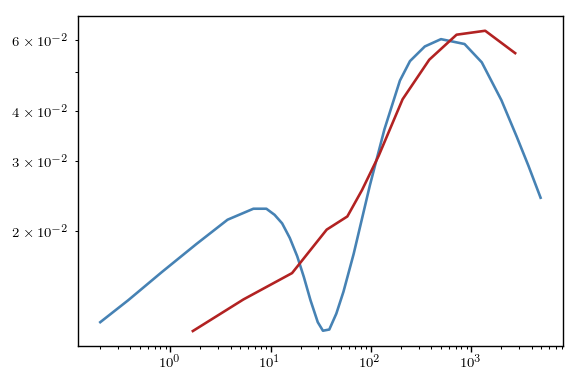

In [8]:
plt.loglog(e_B_vals, e_B_vals**2 * dPhi_dE_dOmega_B_vals)
plt.loglog(e_B_vals_alt, e_B_vals_alt**2 * dPhi_dE_dOmega_B_vals_alt)

In [9]:
# Some parameters
delta_Omega_ref = 1.0e-3 # sr
A_eff_e_ASTROGAM = 500. # cm^2
T_obs_e_ASTROGAM = 365. * 24. * 60.**2 # s
J_fact_draco = 1.0e29 # Draco's J-factor, MeV^2 cm^-5

In [10]:
def photon_count(dPhi_dE_dOmega, e_gam_min, e_gam_max, delta_Omega=delta_Omega_ref, A_eff=A_eff_e_ASTROGAM, T_obs=T_obs_e_ASTROGAM):
    """Computes the number of photons over an energy window for a spectrum.
    
    Parameters
    ----------
    dPhi_dEdOmegas : float -> float
        Function computing the spectrum per solid angle (MeV^-1 sr^-1 cm^-2 s^-1) as a function of photon energy (MeV)
    e_gam_min : float
        Lower bound on photon energy (MeV)
    e_gam_max : float
        Upper bound on photon energy (MeV)
    delta_Omega : float
        Angular size of observation region (sr)
    A_eff : float
        Effective area of experiment (cm^2)
    T_obs : float
        Experiment's observation time (s)
    
    Returns
    -------
    N_gam : float
        Expected number of observed photons over the specified energy range for given experiment and target region parameters
    """
    prefactor = T_obs * A_eff * delta_Omega
    
    return prefactor * integrate.quad(dPhi_dE_dOmega, e_gam_min, e_gam_max)

In [11]:
def compute_limit(dm_spectrum,
                  dPhi_dE_dOmega_B,
                  e_gam_min,
                  e_gam_max,
                  mx,
                  n_sigma=5.,
                  self_conjugate=False,
                  delta_Omega=delta_Omega_ref,
                  J_fact=J_fact_draco,
                  A_eff=A_eff_e_ASTROGAM,
                  T_obs=T_obs_e_ASTROGAM):
    """Computes normalization blah blah blah
    """
    prefactor = T_obs * A_eff * delta_Omega
    
    if self_conjugate:
        dm_fact = 2.
    else:
        dm_fact = 4.
    
    # Get number of background photons
    N_gam_B = prefactor * integrate.quad(dPhi_dE_dOmega_B, e_gam_min, e_gam_max)[0]
    
    # Get number of signal photons
    N_gam_S = prefactor * J_fact / (4. * np.pi * dm_fact * mx**2) * integrate.quad(dm_spectrum, e_gam_min, e_gam_max, args=(mx))[0]
    
    # Signal is "detectable" if c N_S / sqrt(N_B) >= n_sigma. This returns c.
    # If dm_spectrum is dN/dE, then c = <sigma v>. Otherwise, it is a function
    # of the couplings in the model.
    return n_sigma * np.sqrt(N_gam_B) / N_gam_S
    
    ### Alternatively: do the Poisson statistics. TODO: redo in log space
    # Function to compute number of signal photons as a function of the DM spectrum's normalization
#     N_gam_S = lambda c: c * prefactor * J_fact / (4. * np.pi * dm_fact * mx**2) * integrate.quad(dm_spectrum, e_gam_min, e_gam_max)[0]
    
    # Function to compute p-value - alpha for DM annihilation signal as a function of the DM spectrum's normalization
#     p_minus_alpha = lambda c: poisson.cdf(N_gam_S(c), N_gam_B) - alpha
    
    # Find normalization for DM spectrum that saturates confidence level
#     return fsolve(p_minus_alpha, 1.0e-22)

In [13]:
gsxx = 1.0
gsff = 1.0
gsGG = 1.0
gsFF = 0.0
ms = 1.0
mx = mpi

In [14]:
sm = ScalarMediator(mx, ms, gsxx, gsff, gsGG, gsFF)

In [205]:
def dN_dE_1(e_gam, mx):
    if mx > mpi0:
        return decay_neutral_pion.Spectrum(np.array([e_gam]), mx)
    else:
        return 0.0

In [206]:
def compute_limits(dm_spectrum, dPhi_dE_dOmega_B, mx_min, mx_max, n_mxs=100):
    mxs = np.logspace(np.log10(mx_min), np.log10(mx_max), n_mxs)
    limits = []
    
    for mx in mxs:
        if mx < mpi0:
            e_gam_min = 5. # ???
        else:
            e_gam_min = mpi0 / 2.
            
        e_gam_max = mx
        
        limits.append(compute_limit(dm_spectrum, dPhi_dE_dOmega_B, e_gam_min, e_gam_max, mx))
        
    return mxs, np.array(limits)

In [207]:
mxs, limits = compute_limits(dN_dE_1, dPhi_dE_dOmega_B, mpi, 400.)

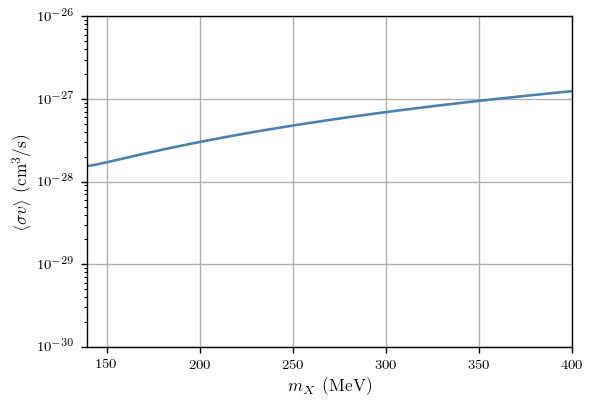

In [227]:
plt.plot(mxs, limits)

plt.grid()
plt.xlim(mxs[[0, -1]])
plt.ylim([1e-30, 1e-26])
plt.yscale("log")
plt.xlabel(r"$m_X$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")